In [ ]:
import os
os.listdir("/mnt/data")


['ml-latest-small']

In [ ]:
os.listdir("/mnt/data/ml-latest-small")


['ml-latest-small']

In [ ]:
os.listdir("/mnt/data/ml-latest-small/ml-latest-small")


['README.txt', 'tags.csv', 'links.csv', 'movies.csv', 'ratings.csv']

In [ ]:
extract_path = "/mnt/data/ml-latest-small/ml-latest-small"

ratings = pd.read_csv(extract_path + "/ratings.csv")
movies  = pd.read_csv(extract_path + "/movies.csv")
tags    = pd.read_csv(extract_path + "/tags.csv")


In [ ]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')


In [ ]:
ratings = ratings.sort_values(['userId', 'timestamp'])


In [ ]:
train = ratings.groupby('userId').apply(
    lambda x: x.iloc[:-1]
).reset_index(drop=True)

test = ratings.groupby('userId').apply(
    lambda x: x.iloc[-1:]
).reset_index(drop=True)


/tmp/ipython-input-963615550.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = ratings.groupby('userId').apply(
/tmp/ipython-input-963615550.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = ratings.groupby('userId').apply(


In [ ]:
print("Train size:", train.shape)
print("Test size:", test.shape)
print("Unique users in test:", test.userId.nunique())


Train size: (100226, 4)
Test size: (610, 4)
Unique users in test: 610


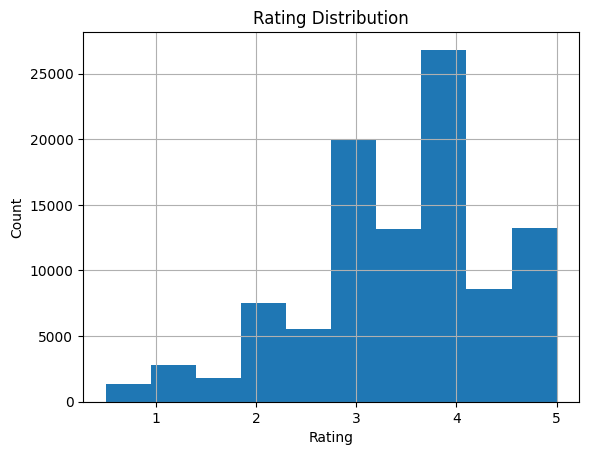

In [ ]:
import matplotlib.pyplot as plt

ratings['rating'].hist(bins=10)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


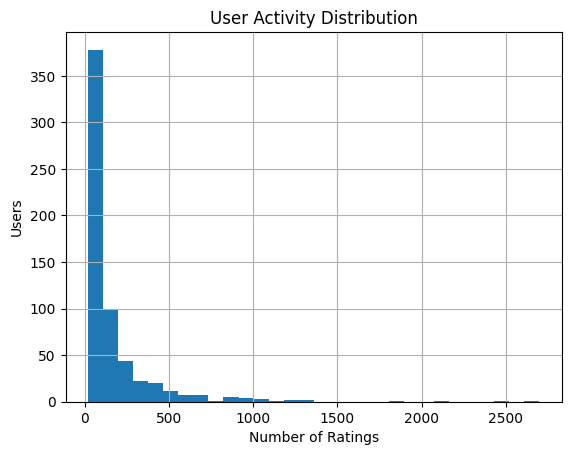

In [ ]:
ratings.groupby('userId').size().hist(bins=30)
plt.title("User Activity Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Users")
plt.show()


In [ ]:
movies['genres'] = movies['genres'].str.split('|')
movies.explode('genres')['genres'].value_counts().head(10)


,count
genres,
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978


In [ ]:
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating','mean'),
    rating_count=('rating','count')
)

popular_movies = movie_stats[movie_stats['rating_count'] > 50] \
                    .sort_values('avg_rating', ascending=False)


In [ ]:
def popular_recommend(k=10):
    return popular_movies.head(k).index.tolist()


In [ ]:
!pip install scikit-surprise

In [ ]:
!pip install "numpy<2.0"


In [ ]:
user_item = train.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)


In [ ]:
user_item.shape


(610, 9701)

In [ ]:
movies['genres'] = movies['genres'].str.split('|')


In [ ]:
all_genres = sorted({g for sub in movies['genres'] if isinstance(sub, list) for g in sub})
for g in all_genres:
    movies[g] = movies['genres'].apply(lambda x: 1 if isinstance(x, list) and g in x else 0)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),NaN
1,2,Jumanji (1995),NaN
2,3,Grumpier Old Men (1995),NaN
3,4,Waiting to Exhale (1995),NaN
4,5,Father of the Bride Part II (1995),NaN


In [ ]:
def build_user_profile(user_id):
    liked_movies = train[
        (train.userId == user_id) & (train.rating >= 4)
    ].movieId

    if len(liked_movies) == 0:
        return None

    user_movies = movies[movies.movieId.isin(liked_movies)]
    return user_movies[all_genres].mean().values


In [ ]:
import numpy as np

def cosine_sim(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


In [ ]:
def content_recommend(user_id, k=10):
    profile = build_user_profile(user_id)
    if profile is None:
        return popular_recommend(k)

    seen = set(train[train.userId == user_id].movieId)
    scores = []

    for _, row in movies.iterrows():
        if row.movieId in seen:
            continue
        movie_vec = row[all_genres].values
        score = cosine_sim(profile, movie_vec)
        scores.append((row.movieId, score))

    scores.sort(key=lambda x: x[1], reverse=True)
    return [m for m,_ in scores[:k]]


In [ ]:
def hybrid_recommend(user_id, alpha=0.7, k=10):
    content_recs = content_recommend(user_id, k=50)

    hybrid_scores = []
    for m in content_recs:
        pop_score = popular_movies.loc[m]['avg_rating'] if m in popular_movies.index else 3
        hybrid_scores.append((m, alpha*pop_score + (1-alpha)))

    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    return [m for m,_ in hybrid_scores[:k]]


In [ ]:
def explain_recommendation(user_id, movie_id):
    liked = train[
        (train.userId == user_id) & (train.rating >= 4)
    ].movieId.head(2)

    liked_titles = movies[movies.movieId.isin(liked)].title.tolist()
    rec_genres = movies[movies.movieId == movie_id].genres.values[0]

    return (
        f"Recommended because you liked {liked_titles}, "
        f"and this movie shares genres such as {rec_genres}."
    )


In [ ]:
def catalog_coverage(all_recs):
    return len(set(all_recs)) / movies.movieId.nunique()


In [ ]:
from itertools import combinations

def intra_list_diversity(movie_list):
    vecs = movies[movies.movieId.isin(movie_list)][all_genres].values
    sims = []
    for a,b in combinations(vecs,2):
        sims.append(cosine_sim(a,b))
    return 1 - np.mean(sims)


In [ ]:
user = 1
recs = hybrid_recommend(user)

for m in recs:
    title = movies[movies.movieId == m].title.values[0]
    print(title)
    print(explain_recommendation(user, m))
    print()


Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as nan.

Casino (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as nan.

Dead Man Walking (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as nan.

Sense and Sensibility (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as nan.

American President, The (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as nan.

Babe (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return o

In [ ]:
movies['genres'] = movies['genres'].fillna('Unknown')
movies['genres'] = movies['genres'].apply(
    lambda x: x if isinstance(x, str) else '|'.join(x)
)


In [ ]:
def explain_recommendation(user_id, movie_id):
    liked = train[
        (train.userId == user_id) & (train.rating >= 4)
    ].movieId.head(2)

    liked_titles = movies[movies.movieId.isin(liked)].title.tolist()

    genres = movies[movies.movieId == movie_id].genres.values[0]

    if genres == 'Unknown' or genres == 'no genres listed':
        genre_text = "similar themes"
    else:
        genre_text = genres.replace('|', ', ')

    return (
        f"Recommended because you liked {liked_titles}, "
        f"and this movie shares genres such as {genre_text}."
    )


In [ ]:
user = 1
recs = hybrid_recommend(user)

for m in recs:
    title = movies[movies.movieId == m].title.values[0]
    print(title)
    print(explain_recommendation(user, m))
    print()


Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as similar themes.

Casino (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as similar themes.

Dead Man Walking (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as similar themes.

Sense and Sensibility (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as similar themes.

American President, The (1995)
Recommended because you liked ["She's the One (1996)", 'Star Wars: Episode VI - Return of the Jedi (1983)'], and this movie shares genres such as similar themes.

Babe (1995)
Recommended because you liked ["S

In [ ]:
def precision_at_k(recommended, relevant):
    return len(set(recommended) & set(relevant)) / len(recommended)
